<a href="https://colab.research.google.com/github/antonisapostoloudis/6th-Assignment-Machine-Learning/blob/main/6th_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εργασία 6 - Data engineering

## Ερώτημα 1

# Διάβασμα δεδομένων

In [ ]:
import pandas as pd
!pip install ydata-profiling
from ydata_profiling import ProfileReport
df = pd.read_csv("bankloan.csv")


# Περιγραφή μεταβλητών με ydata_profiling

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

## Ερώτημα 2 (Data Preprocessing & Visualization)

### Ελάχιστο, μέγιστο και μέσο loan_amnt

Από το profiling dashboard, επιλέγοντας την μεταβλητή loan_amnt βλέπουμε πως:
Ελάχιστο: 1000
Μέγιστο:35000
Μέσο: 15257.966

### Αφαίρεση μεταβλητών

In [ ]:
# Διαγράφουμε τις ID στήλες
id_cols = [
    "Row ID",
    "id",
    "member_id"
]

# Διαγράφουμε junk στήλες
junk_cols = [
    "Unnamed: 50"
]

# Διαγράφουμε στήλες που δεν γνωρίζουμε στο prediction time
leak_cols = [
    "last_pymnt_d",
    "last_pymnt_amnt",
    "next_pymnt_d",
    "last_credit_pull_d",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "out_prncp ",
    'earliest_cr_line'

]

# Διαγράφουμε στήλες με παρα πολύ low variance
lv_cols = [
    "application_type",
    "acc_now_delinq"

]

# Διαγράφουμε στήλες με >99% missing values
mv_cols = [
    "dti_joint",
    "annual_inc_joint"

]

# ιδια πληροφορία με 36 και 60 months,απλά έχει γίνει one-hot encoding
cols_to_drop = id_cols + junk_cols + leak_cols + mv_cols + lv_cols + ["term"]
# ιδια πληροφορία με loan_amnt
cols_to_drop = cols_to_drop + ['funded_amnt']

cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df_clean = df.drop(columns=cols_to_drop, axis=1)
df_clean = df_clean.drop(columns=["emp_title","issue_d"])
print("Dropped columns:")
for col in cols_to_drop:
    print(" -", col)


print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

Dropped columns:
 - Row ID
 - id
 - member_id
 - Unnamed: 50
 - last_pymnt_d
 - last_pymnt_amnt
 - next_pymnt_d
 - last_credit_pull_d
 - total_rec_prncp
 - total_rec_int
 - total_rec_late_fee
 - recoveries
 - collection_recovery_fee
 - earliest_cr_line
 - dti_joint
 - annual_inc_joint
 - application_type
 - acc_now_delinq
 - term
 - funded_amnt

Original shape: (212999, 53)
Cleaned shape: (212999, 31)


### Further Preprocessing

In [ ]:
num_cols = df_clean.select_dtypes(include=['float64','int64']).columns
cat_cols = df_clean.select_dtypes(include=['object']).columns

df_clean[num_cols] = df_clean[num_cols].fillna(df[num_cols].median())
df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")
df_clean.isna().sum()

,0
loan_amnt,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0
annual_inc,0
verification_status,0
loan_status,0


### Ερώτημα 2.4

In [ ]:
# Δημιουργούμε target: 1 = approved, 0 = not approved
df_clean["approved"] = 0   # default

# 1) Όλα τα grade = "A"
df_clean.loc[df_clean["grade"] == "A", "approved"] = 1

# 2) Μόνο τα B1 και B2 από το sub_grade
df_clean.loc[df_clean["sub_grade"].isin(["B1", "B2"]), "approved"] = 1

df_clean["approved"].value_counts()


,count
approved,
0,151709
1,61290


Δηλαδή περίπου 28,7% approved και 71,3% not approved → το target είναι ανισόρροπο (imbalanced), αλλά όχι σε ακραίο επίπεδο.

### Ερώτημα 2.5

In [ ]:
# Δημιουργούμε τα διαστήματα και τα αντίστοιχα labels
bins = list(range(0, 50001, 5000))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

df_clean["loan_bin"] = pd.cut(
    df_clean["loan_amnt"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Πιθανότητα για approved ανα διάστημα
approval_rates = df_clean.groupby("loan_bin")["approved"].mean()

print("Approval rates per loan range:")
print(approval_rates)

# Διαστήματα με approval >= 15%
valid_ranges = approval_rates[approval_rates >= 0.15]

print("\nLoan amount ranges with approval rate >= 15%:")
print(valid_ranges)

Approval rates per loan range:
loan_bin
0-5000         0.248018
5000-10000     0.352425
10000-15000    0.290306
15000-20000    0.282640
20000-25000    0.283728
25000-30000    0.279096
30000-35000    0.127053
35000-40000         NaN
40000-45000         NaN
45000-50000         NaN
Name: approved, dtype: float64

Loan amount ranges with approval rate >= 15%:
loan_bin
0-5000         0.248018
5000-10000     0.352425
10000-15000    0.290306
15000-20000    0.282640
20000-25000    0.283728
25000-30000    0.279096
Name: approved, dtype: float64


/tmp/ipython-input-2394503172.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rates = df_clean.groupby("loan_bin")["approved"].mean()


Όλα τα εύρη έως 30.000 USD έχουν approval rate >15%, εκτός από 30.000–35.000 όπου πέφτει στο 12.7%.

# Ερώτημα 3. Classification

### Χωρισμός δεδομένων σε train και test

In [ ]:
from sklearn.model_selection import train_test_split

#grade και subgrade προδίδουν άμερα το target μας(approved)
X = df_clean.drop(columns=["approved", "grade", "sub_grade"])
y = df_clean["approved"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

### Normalization, Classification και Metrics

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

scaler = StandardScaler()

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

clf = LogisticRegression(max_iter=2000, class_weight="balanced")
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", clf)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy: 0.9998122065727699
Precision: 0.9993477906407957
Recall: 1.0
F1 score: 0.9996737889414451


Η πιο σημαντική μετρική είναι η Precision, επειδή μειώνει την πιθανότητα ενός False Positive, δηλαδή την περίπτωση όπου το μοντέλο εγκρίνει έναν υποψήφιο που δεν θα έπρεπε να λάβει δάνειο, κάτι που έχει μεγάλο οικονομικό κόστος για την τράπεζα. Η Recall είναι επίσης σημαντική, αλλά σε μικρότερο βαθμό, καθώς αναφέρεται στο πόσους από τους πραγματικά καλούς υποψήφιους εγκρίνουμε· ένα χαμηλό Recall σημαίνει απώλεια δυνητικών κερδών, όχι όμως άμεση οικονομική ζημιά. Το F1-score παρέχει μια ισορροπία μεταξύ Precision και Recall και είναι χρήσιμο όταν θέλουμε να αξιολογήσουμε συνολικά την απόδοση του μοντέλου. Αντίθετα, η Accuracy δεν είναι αξιόπιστη σε αυτό το πλαίσιο, ειδικά όταν το dataset είναι μη ισορροπημένο, καθώς μπορεί να παραπλανήσει και να υποτιμήσει το κόστος των λανθασμένων εγκρίσεων δανείων.

# Ερώτημα 4. Feature Importance & Selection

## Εκπαίδευση Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

pipeline_rf = Pipeline([
    ("preprocess", preprocessor),
    ("rf", rf)
])

pipeline_rf.fit(X_train, y_train)

encoded_cols = list(pipeline_rf.named_steps["preprocess"].transformers_[1][1].get_feature_names_out(categorical_features))
all_features = list(numeric_features) + encoded_cols

# Feature importances
importances = pipeline_rf.named_steps["rf"].feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top15 = feat_imp.head(15)
print(top15)

                             feature  importance
1                           int_rate    0.775412
11                        revol_util    0.020801
19                  total_rev_hi_lim    0.019837
2                        installment    0.016770
4                                dti    0.015895
13                         out_prncp    0.015017
38  verification_status_Not Verified    0.014509
40      verification_status_Verified    0.012664
3                         annual_inc    0.011420
6                     inq_last_6mths    0.011269
0                          loan_amnt    0.010068
58     title_Credit card refinancing    0.008266
10                         revol_bal    0.007200
18                       tot_cur_bal    0.007125
44               purpose_credit_card    0.006570


## Correlation Matrix

In [ ]:
top_features = top15["feature"].tolist()

# Κρατάμε μόνο numeric columns (OHE δεν χρειάζεται correlation)
numeric_top_features = [f for f in top_features if f in numeric_features]

corr_matrix = X_train[numeric_top_features].corr()

print(corr_matrix)

                  int_rate  revol_util  total_rev_hi_lim  installment  \
int_rate          1.000000    0.206024         -0.195728     0.118546   
revol_util        0.206024    1.000000         -0.105978     0.129197   
total_rev_hi_lim -0.195728   -0.105978          1.000000     0.327569   
installment       0.118546    0.129197          0.327569     1.000000   
dti               0.050736    0.043209          0.018359     0.001913   
out_prncp         0.136346    0.127470          0.346106     0.899283   
annual_inc       -0.081818    0.037885          0.248027     0.259403   
inq_last_6mths    0.231114   -0.093317          0.012258    -0.008353   
loan_amnt         0.143519    0.129495          0.356926     0.942508   
revol_bal        -0.056575    0.240128          0.847319     0.313189   
tot_cur_bal      -0.085530    0.099276          0.438256     0.294690   

                       dti  out_prncp  annual_inc  inq_last_6mths  loan_amnt  \
int_rate          0.050736   0.136346   -0.

Από το correlation matrix των 15 σημαντικότερων χαρακτηριστικών παρατηρούμε ότι ορισμένα ζεύγη μεταβλητών εμφανίζουν υψηλή συσχέτιση. Συγκεκριμένα, μεταβλητές όπως loan_amnt και installment είναι έντονα συσχετισμένες, καθώς το ύψος δανείου επηρεάζει άμεσα τη δόση. Οι περισσότερες όμως μεταβλητές παρουσιάζουν χαμηλό ή μέτριο correlation, κάτι που υποδεικνύει ότι συμβάλλουν με διαφορετική πληροφορίας στο μοντέλο. Αυτές οι μεταβλητές μπορούν να διατηρηθούν για την εκπαίδευση.

## Επιλογή χαρακτηριστικών με χαμηλό correlation

In [ ]:
selected_features = []

for col in numeric_top_features:
    max_corr = corr_matrix[col].drop(col).abs().max()
    if max_corr < 0.4:
        selected_features.append(col)

print("Selected low-correlation features:", selected_features)

Selected low-correlation features: ['int_rate', 'revol_util', 'dti', 'annual_inc', 'inq_last_6mths']


## Επανεκπαιδευση

In [ ]:
df_selected = df_clean[selected_features]

X = df_selected
y = df_clean["approved"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", "passthrough", categorical_features)
    ]
)

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("rf", model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("Accuracy:",  round(acc,4))
print("Precision:", round(prec,4))
print("Recall:",    round(rec,4))
print("F1 Score:",  round(f1,4))

Accuracy: 0.9999
Precision: 0.9998
Recall: 1.0
F1 Score: 0.9999


# Ερώτημα 5 (Dimensionality Reduction)


## Φόρτωμα δεδομένων

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Train images:", x_train.shape)
print("Test images:", x_test.shape)

5
Train images: (60000, 28, 28)
Test images: (10000, 28, 28)


## Standard Scaling στα δεδομένα

In [ ]:
from sklearn.preprocessing import StandardScaler

x_train_flat = x_train.reshape(len(x_train), -1)
x_test_flat  = x_test.reshape(len(x_test), -1)


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled  = scaler.transform(x_test_flat)

print("Train scaled:", x_train_scaled.shape)
print("Test scaled:", x_test_scaled.shape)

Train scaled: (60000, 784)
Test scaled: (10000, 784)


## PCA στα δεδομένα

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pca = PCA(n_components=300)

x_train_pca = pca.fit_transform(x_train_scaled)   # FIT + TRANSFORM on train
x_test_pca = pca.transform(x_test_scaled)

k_values = [5, 15, 51, 101]
accuracies = {}


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    y_pred = knn.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracies[k] = acc
    print(f"K = {k} → Accuracy = {acc:.4f}")

K = 5 → Accuracy = 0.9497
K = 15 → Accuracy = 0.9436
K = 51 → Accuracy = 0.9273
K = 101 → Accuracy = 0.9158


Η μέθοδος PCA πρέπει πάντα να «εκπαιδεύεται» μόνο στο training set, γι’αυτό εφαρμόζουμε pca.fit_transform() αποκλειστικά στα δεδομένα εκπαίδευσης και στη συνέχεια χρησιμοποιούμε μόνο pca.transform() στο test set. Αν κάναμε fit ξεχωριστά στο train και στο test, το PCA θα υπολόγιζε διαφορετικούς άξονες για κάθε σύνολο, με αποτέλεσμα τα δεδομένα να βρίσκονται σε διαφορετικό χώρο και ο ταξινομητής (όπως το KNN) να συγκρίνει ασύμβατα χαρακτηριστικά, οδηγώντας σε πολύ χαμηλή ακρίβεια. Αν αντίθετα κάναμε fit στο ενωμένο σύνολο train+test, τότε το PCA θα «μάθαινε» πληροφορίες από το test set πριν την αξιολόγηση, δημιουργώντας τεχνητά αυξημένη απόδοση που δεν αντιστοιχεί σε πραγματική γενίκευση. Έτσι, η σωστή και αυστηρή διαδικασία είναι: scaling → PCA fit μόνο στο train → PCA transform στο test → εκπαίδευση/αξιολόγηση του ταξινομητή σε αυτά τα κοινά, συνεπή χαρακτηριστικά.

## LDA στα δεδομένα

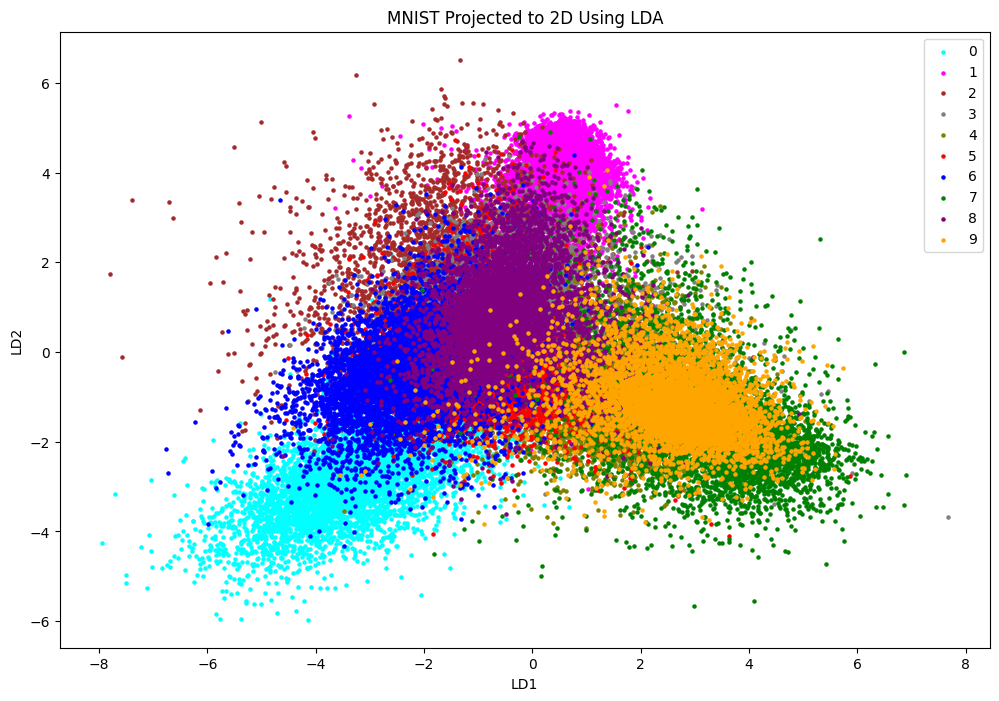

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

lda = LinearDiscriminantAnalysis(n_components=2)
x_train_lda = lda.fit_transform(x_train_scaled, y_train)
x_test_lda  = lda.transform(x_test_scaled)

plt.figure(figsize=(12,8))

colors = [
    "cyan", "magenta", "brown", "gray", "olive", "red", "blue", "green", "purple", "orange"
]

for digit in range(10):
    idx = np.where(y_train == digit)
    plt.scatter(
        x_train_lda[idx, 0],
        x_train_lda[idx, 1],
        s=5,
        color=colors[digit],
        label=str(digit)
    )

plt.title("LDA Scatter Plot")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.show()

Παρατηρούμε πως τα τα ψηφία σχηματίζουν διακριτά clusters, δηλαδή ομάδες σημείων που βρίσκονται κοντά μεταξύ τους στον χώρο των δύο γραμμικών διακριτικών συνιστωσών (LD1 και LD2). Ορισμένες κλάσεις, όπως τα ψηφία 0, 1, 6, εμφανίζουν πολύ καλό διαχωρισμό και σχηματίζουν καθαρά, συμπαγή clusters που δεν επικαλύπτονται ιδιαίτερα με άλλες κλάσεις. Παρόλα αυτά, ψηφία που μοιάζουν περισσότερο μεταξύ τους — όπως τα 3, 5 και 8, ή τα 4, 7 και 9 — εμφανίζουν περιοχές με επικάλυψη λόγω του ότι έχουν πιο παρόμοια μορφολογικά χαρακτηριστικά. Επειδή το LDA μπορεί να δημιουργήσει το πολύ 9 διαστάσεις για πρόβλημα με 10 κλάσεις, η συμπίεση σε μόλις 2 διαστάσεις δεν επιτρέπει πλήρη διαχωρισμό. Ωστόσο, το διάγραμμα δείχνει ξεκάθαρη ομαδοποίηση και σημαντική βελτίωση στον διαχωρισμό σε σύγκριση με μη επιβλεπόμενες μεθόδους όπως το PCA.

## UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


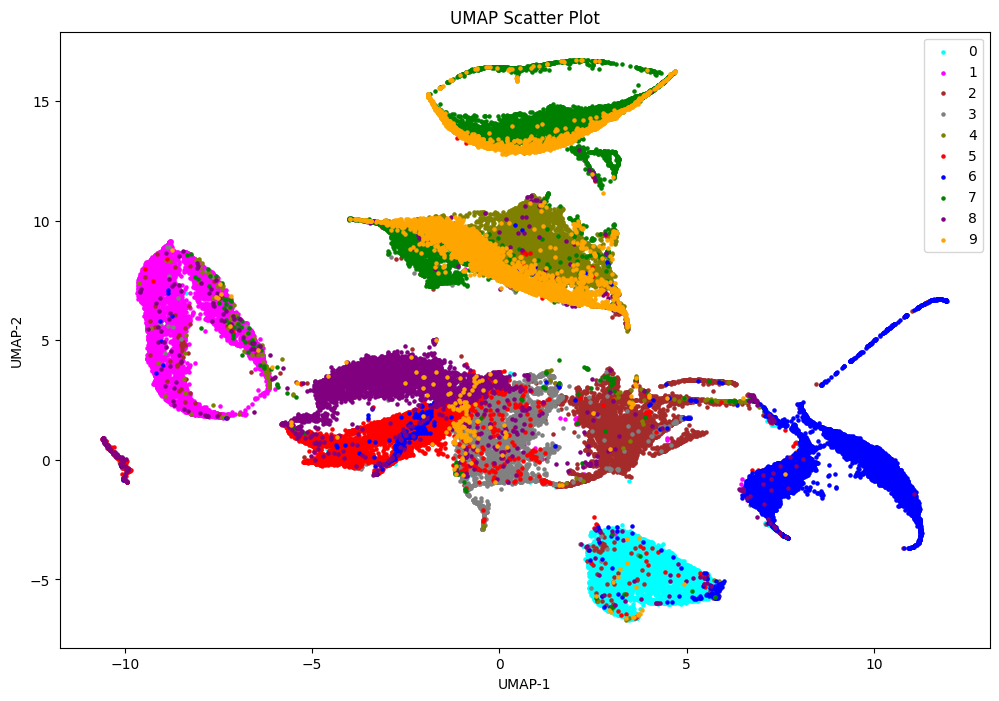

In [ ]:

import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42)
x_train_umap = umap_model.fit_transform(x_train_scaled)


colors = [
    "cyan", "magenta", "brown", "gray", "olive", "red", "blue", "green", "purple", "orange"
]

# 6. Scatter Plot
plt.figure(figsize=(12,8))

for digit in range(10):
    idx = np.where(y_train == digit)
    plt.scatter(
        x_train_umap[idx, 0],
        x_train_umap[idx, 1],
        s=5,
        color=colors[digit],
        label=str(digit)
    )

plt.title("UMAP Scatter Plot")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()

Η LDA, επειδή βασίζεται αποκλειστικά σε γραμμικούς μετασχηματισμούς, δημιουργεί έναν αρκετά περιορισμένο διαχωρισμό των ψηφίων στο επίπεδο: ορισμένες κατηγορίες διακρίνονται ικανοποιητικά, αλλά πολλές ομάδες παραμένουν κοντά ή επικαλύπτονται, ιδίως όταν τα ψηφία έχουν παρόμοια μορφή. Αντίθετα, η UMAP αξιοποιεί μη γραμμικές σχέσεις και «μαθαίνει» την πραγματική γεωμετρία των δεδομένων, με αποτέλεσμα να εμφανίζει πολύ πιο καθαρά και απομονωμένα clusters. Στο γράφημα της UMAP, οι περισσότερες κατηγορίες ψηφίων σχηματίζουν σαφώς διαχωρισμένες περιοχές, και ακόμη τα πιο «δύσκολα» ψηφία παρουσιάζουν καλύτερη οπτική διαφοροποίηση σε σύγκριση με την LDA. Συνολικά, η UMAP επιτυγχάνει αισθητά ανώτερο διαχωρισμό σε δύο διαστάσεις, επειδή μπορεί να αποκαλύψει πολύπλοκες δομές που η LDA δεν είναι σε θέση να συλλάβει.